In [1]:
import logging


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

In [9]:
from src.datasets.cifar10_dataset import MiniCIFAR10Dataset
from src.datasets.mnist_dataset import MiniMNIST32x32Dataset
from src.experiment1 import VGGBuilder, run_experiment1, LeNet5Builder as OriginalLeNet5Builder
from src.models.compression.enums import Activation, NNParamsCompMode
from src.models.eval import NNArchitectureEvaluator
from src.models.nn import ActivationParams


params = VGGBuilder().get_params(
    MiniCIFAR10Dataset,
    conv_compression=NNParamsCompMode.NONE,
    conv_bitwidth=8,
    conv_activation=ActivationParams(Activation.RELU),
    fc_compression=NNParamsCompMode.BINARY,
    fc_bitwidth=8,
    fc_activation=ActivationParams(Activation.RELU),
)
evaluator = NNArchitectureEvaluator(params.train)
evaluator.evaluate_complexity(params)

170988195.0

In [10]:
params.get_model()

CNN(
  (quantize_input): Identity()
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2dWrapper(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2dWrapper(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2dWrapper(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2dWrapper(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

In [11]:
from src.models.builders.architecture_builder import BuilderParams
from src.models.builders.LeNet5_builder import LeNet5Builder
from src.models.builders.VGGNet_builder import VGGNetBuilder

builder_params = BuilderParams(
    conv_compression=NNParamsCompMode.NONE,
    conv_bitwidth=8,
    conv_activation=ActivationParams(Activation.RELU),
    fc_compression=NNParamsCompMode.BINARY,
    fc_bitwidth=8,
    fc_activation=ActivationParams(Activation.RELU),
    DatasetCls=MiniCIFAR10Dataset,
)
builder = VGGNetBuilder(builder_params)
params = builder.get_params()
params.get_model()

CNN(
  (quantize_input): Identity()
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2dWrapper(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2dWrapper(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2dWrapper(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2dWrapper(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:

import pandas as pd

from src.constants import REPORTS_FOLDER
from src.experiment1 import run


# df = run_on_dataset(MiniMNIST32x32Dataset, 3, 1)
# df.to_csv("tmp.csv", index=False)
df = pd.read_csv(REPORTS_FOLDER + "/2025-06-01T08:47:50/experiment1_results.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   architecture      16 non-null     object 
 1   dataset           16 non-null     object 
 2   conv_compression  16 non-null     object 
 3   conv_activation   16 non-null     object 
 4   fc_compression    16 non-null     object 
 5   fc_activation     16 non-null     object 
 6   best              16 non-null     float64
 7   mean              16 non-null     float64
 8   accuracies        16 non-null     object 
 9   cost              16 non-null     float64
dtypes: float64(3), object(7)
memory usage: 1.4+ KB


,architecture,dataset,conv_compression,conv_activation,fc_compression,fc_activation,best,mean,accuracies,cost
0,LeNet5,MiniMNISTDataset,BINARY,NONE,BINARY,NONE,92.625,90.150,"[89.875, 89.75, 92.625, 87.5, 91.0]",33354.0
1,LeNet5,MiniMNISTDataset,TERNARY,NONE,TERNARY,NONE,81.750,79.475,"[77.625, 79.625, 81.75, 79.875, 78.5]",66258.0
2,LeNet5,MiniMNISTDataset,NBITS,NONE,NBITS,NONE,83.500,78.425,"[83.5, 77.875, 79.25, 76.625, 74.875]",263682.0
3,LeNet5,MiniMNISTDataset,NONE,NONE,NONE,NONE,93.250,92.700,"[93.0, 92.875, 93.25, 93.25, 91.125]",1053378.0
4,LeNet5,MiniMNISTDataset,BINARY,BINARIZE,BINARY,BINARIZE,82.750,81.925,"[82.75, 82.0, 82.5, 82.5, 79.875]",53154.0


In [9]:
relu_df = df.loc[df["conv_activation"] == "RELU"]
relu_df

,architecture,dataset,conv_compression,conv_activation,fc_compression,fc_activation,best,mean,accuracies,cost
12,LeNet5,MiniMNISTDataset,BINARY,RELU,BINARY,RELU,93.375,90.850,"[91.25, 91.0, 93.375, 89.5, 89.125]",251010.0
13,LeNet5,MiniMNISTDataset,TERNARY,RELU,TERNARY,RELU,76.625,70.025,"[65.75, 66.875, 76.625, 67.25, 73.625]",303570.0
14,LeNet5,MiniMNISTDataset,NBITS,RELU,NBITS,RELU,82.625,78.950,"[79.625, 76.75, 81.75, 74.0, 82.625]",618930.0
15,LeNet5,MiniMNISTDataset,NONE,RELU,NONE,RELU,96.750,94.975,"[94.625, 95.25, 96.75, 93.25, 95.0]",1880370.0


In [10]:
import plotly.express as px

px.scatter(
    df,
    x="best",
    y="cost",
    color="conv_activation",
    symbol="conv_compression",
    title="Experiment 1: MiniMNIST32x32Dataset",
    labels={
        "conv_bitwidth": "Convolutional Layer Bitwidth",
        "fc_bitwidth": "Fully Connected Layer Bitwidth",
        "mean": "Accuracy (%)"
    }
).show()


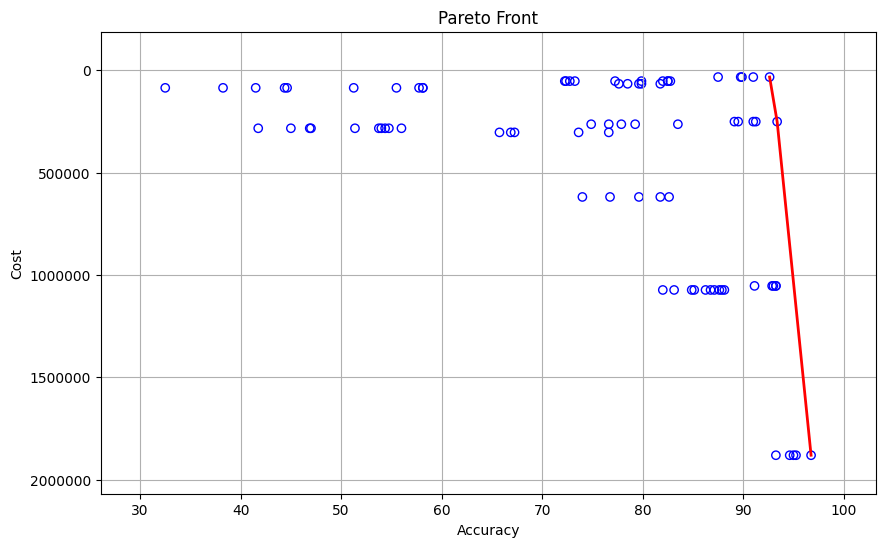

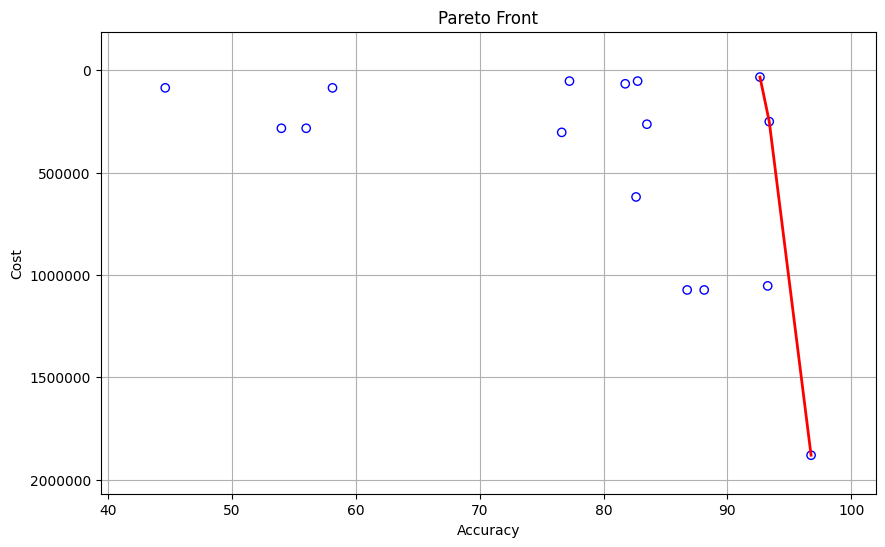

In [11]:
from matplotlib import pyplot as plt
import numpy as np

from src.nas.plot import plot_pareto_front


acc = []
cost = []
for _, row in df.iterrows():
    accuracies = row["accuracies"] if isinstance(row["accuracies"], list) else row["accuracies"].strip("[]").split(", ")
    for accuracy in accuracies:
        acc.append(float(accuracy))
        cost.append(row["cost"])

fig = plot_pareto_front(acc, cost)
fig = plot_pareto_front(df["best"], df["cost"])



In [35]:
import plotly.express as px

fig = px.scatter(
    df,
    x="best",
    y="cost",
    color="conv_compression",
    title="Best Accuracy vs Cost (MiniMNIST32x32Dataset)",
    hover_data=["conv_activation", "conv_compression"],
    labels={
        "cost": "Model Cost",
        "best": "Best Accuracy (%)",
        "conv_activation": "Conv Activation",
        "conv_compression": "Conv Compression"
    }
)
fig.update_yaxes(autorange="reversed")
fig.show()